# Video pipeline with Yolo + Resnet Model

In [24]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal_final, draw_cumulative

In [25]:
# serieses = [116, 117, 118, 119, 120]
serieses = [153, 154]

series_paths = {series: os.path.join(FINAL_RESULTS_PATH, "series", str(series)) for series in serieses}

loaders = {series: AdaptationParser(series_path=series_path, model_name="video", type_of="router_pipeline") for series, series_path in series_paths.items()}

In [26]:
loaders

{153: <experiments.utils.parser.AdaptationParser at 0x7fd1ed8a9790>,
 154: <experiments.utils.parser.AdaptationParser at 0x7fd1ed8a9fa0>}

In [27]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp['0.yaml']
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 153 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 20,
    'allocation_mode': 'base',
    'alpha': 0,
    'baseline_mode': 'scale',
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 10000,
    'gamma': 0,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'metadata': 'teleport 10 and margin 30%',
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 10,
    'nodes': [   {   'cpu_request': '1',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
                     'memory_request': '2Gi',
                     'model_variants': 'yolov5n',
                     'node_name': 'yolo',
                  

In [28]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [29]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{153: False, 154: False}

In [30]:
adaptation_logs = dict(map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items()))

In [31]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(adaptation_log=adaptation_logs[series])

## Comparing Predicted Load with the Recieved Load

300
290


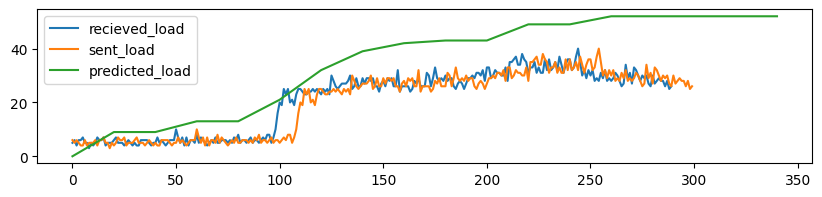

300
290


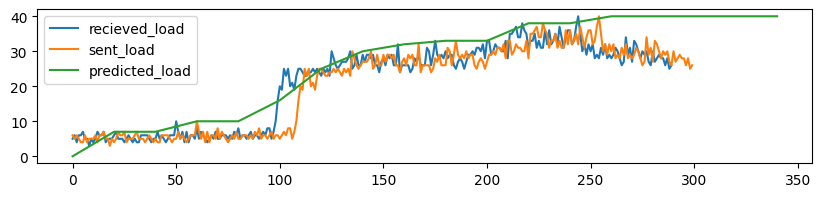

In [32]:
# --- sent and recieved load ---
for series, series_dict in series_changes.items():
    recieved_load = series_changes[series]["recieved_load"]
    predicted_load = series_changes[series]["predicted_load"]
    # recieved_load = [int(item) for item in recieved_load if item != 0]
    recieved_load_x = [x for x in range(0, len(recieved_load))]
    sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    predicted_load_x = series_changes[series]["time_interval"]
    print(len(sent_loads[series]))
    print(len(recieved_load))
    plt.figure(figsize=(10, 2))
    plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    plt.plot(sent_load_x, sent_loads[series], label="sent_load")
    plt.plot(predicted_load_x, predicted_load, label="predicted_load")
    # TODO add predicted reference load here
    plt.legend()
    plt.show()


In [34]:

# --- replica changes ---
final_dict = {}
final_dict["replica_changes"] = {}
final_dict["core_changes"] = {}
final_dict["total_core_changes"] = {}
final_dict["accuracy_changes"] = {}
final_dict["batching_changes"] = {}
final_dict["throughput_changes"] = {}
final_dict["latency_changes"] = {}
# final_dict["per_second_results"] = {}
metric = "p99" # [min, max, p99]
final_dict["metrics_all"] = {}
final_dict["change_trigger"] = {}
final_dict["objective_changes"] = {}
final_dict["timeout_dics"] = {}

for series, series_dict in series_changes.items():

    final_dict["replica_changes"][series] = {}
    final_dict["core_changes"][series] = {}
    final_dict["total_core_changes"][series] = {}
    final_dict["accuracy_changes"][series] = {}
    final_dict["batching_changes"][series] = {}
    final_dict["throughput_changes"][series] = {}
    final_dict["latency_changes"][series] = {}
    final_dict["change_trigger"][series] = {}
    final_dict["objective_changes"][series] = {}

    for node_name, metrics in series_changes[series]["nodes"].items():
        final_dict["replica_changes"][series][node_name] = metrics["replicas"]
        final_dict["core_changes"][series][node_name] = metrics["cpu"]
        final_dict["accuracy_changes"][series][node_name] = metrics["accuracy"]
        final_dict["batching_changes"][series][node_name] = metrics["batch"]
        final_dict["throughput_changes"][series][node_name] = metrics["throughput"]
        final_dict["latency_changes"][series][node_name] = metrics["latency"]
    if not simulation_modes[series]:
        timeout_per_second, per_second_results = loaders[series].per_second_result_processing()
    else:
        timeout_per_second, per_second_results = None, None
    if not simulation_modes[series]:
        metric_columns = list(filter(lambda col: metric in col, per_second_results.columns))
        final_dict["metrics_all"][series] = per_second_results[metric_columns]
        final_dict["metrics_all"][series] = final_dict["metrics_all"][series].to_dict(orient="list")

    final_dict["change_trigger"][series] = loader.points_with_change(adaptation_log=adaptation_logs[series])

    final_dict["objective_changes"][series]["objective"] = series_changes[series]["objective"]

    if not simulation_modes[series]:
        final_dict["timeout_dics"][series] = {"timeout_per_second": timeout_per_second}


    # totals
    final_dict["replica_changes"][series]["total"] = [sum(x) for x in zip(*final_dict["replica_changes"][series].values())]
    final_dict["core_changes"][series]["total"] = [sum(x) for x in zip(*final_dict["core_changes"][series].values())]
    if accuracy_methods[series] == "sum":
        final_dict["accuracy_changes"][series]["e2e"] = [sum(x) for x in zip(*final_dict["accuracy_changes"][series].values())]
    final_dict["throughput_changes"][series]["e2e"] = [min(x) for x in zip(*final_dict["throughput_changes"][series].values())]
    final_dict["latency_changes"][series]["e2e"] = [sum(x) for x in zip(*final_dict["latency_changes"][series].values())]
    final_dict["change_trigger"][series]["all"] = [any(x) for x in zip(*final_dict["change_trigger"][series].values())]

    for key in final_dict["replica_changes"][series].keys():
        final_dict["total_core_changes"][series][key] = [
            x * y for x, y in zip(final_dict["replica_changes"][series][key], final_dict["core_changes"][series][key])
        ]

a = 1

# def reformat_dict(input_dict):
#     reformatted_dict = {}
#     for key, inner_dict in input_dict.items():
#         for inner_key, value in inner_dict.items():
#             new_key = str(key) + '-' + str(inner_key)
#             reformatted_dict[new_key] = value
#     return reformatted_dict

# final_dict = reformat_dict(final_dict)

draw_temporal_final(final_dict, adaptation_intervals, multiple_experiments=True)

# Paper ready figures

In [ ]:
"""
1. Temporal could be on the showing both nodes
2. 
"""

'\n1. Temporal could be on the showing both nodes\n2. \n'